In [41]:
import requests

import numpy as np # linear algebra
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm

from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader 
from transformers import DistilBertTokenizer, DistilBertModel

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dishes/all_in_one.csv


In [42]:
from torch import cuda
device = torch.device('cpu')

print(f"Current device: {device}")

Current device: cpu


In [43]:
def get_dishes(id,page):
    url = 'https://market-backend.api.2gis.ru/5.0/product/items_by_branch?branch_id='+f'{id}'+'&locale=ru_RU&page=1&page_size=50&page='+f'{page}'
    print(url)
    response = (requests.get(url)).json()
    items = []
    dishes = []
    descriptions = []
    for element in response['result']['items']:
        # print(element['result']['name'] + ' (' + str(element['resultScore']) + ')')
        items.append(element)
    for item in items:
      name = item['product']['name']
      dishes.append(name)
    for dish in items:
      description = dish['product']['description']
      descriptions.append(description)
    return dishes, descriptions

In [44]:
all_items = pd.read_csv("/kaggle/input/dishes/all_in_one.csv")
df2 = pd.DataFrame(columns=['id', 'dishes','description'])


In [45]:
for element in all_items['id']:
    #print(element)
    values_list, descriptions = get_dishes(element,1)
    # values_list = dfs['text'].tolist()
    #print(values_list)
    #print(descriptions)
    dfs_= pd.DataFrame({'id': [element], 'dishes': [values_list], 'description':[descriptions]})
    df2 = df2.append(dfs_, ignore_index=True)

df2

https://market-backend.api.2gis.ru/5.0/product/items_by_branch?branch_id=70000001056052192&locale=ru_RU&page=1&page_size=50&page=1
https://market-backend.api.2gis.ru/5.0/product/items_by_branch?branch_id=70000001039197290&locale=ru_RU&page=1&page_size=50&page=1
https://market-backend.api.2gis.ru/5.0/product/items_by_branch?branch_id=70000001007548790&locale=ru_RU&page=1&page_size=50&page=1
https://market-backend.api.2gis.ru/5.0/product/items_by_branch?branch_id=70000001033092714&locale=ru_RU&page=1&page_size=50&page=1
https://market-backend.api.2gis.ru/5.0/product/items_by_branch?branch_id=70000001069065093&locale=ru_RU&page=1&page_size=50&page=1
https://market-backend.api.2gis.ru/5.0/product/items_by_branch?branch_id=70000001065471097&locale=ru_RU&page=1&page_size=50&page=1
https://market-backend.api.2gis.ru/5.0/product/items_by_branch?branch_id=422741746350056&locale=ru_RU&page=1&page_size=50&page=1
https://market-backend.api.2gis.ru/5.0/product/items_by_branch?branch_id=700000010347

,id,dishes,description
0,70000001056052192,"[Шаурма ""Классика"" норм, Шаурма ""Классика"" бол...","[Ароматный лаваш, капуста, морковь, свежий огу..."
1,70000001039197290,"[Брускетты с жаренными лесными грибами, Бруске...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
2,70000001007548790,"[Шашлык ""Ребрышки из свинины"", Шашлык ""Свиной ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
3,70000001033092714,[],[]
4,70000001069065093,"[Цезарь с курицей, Греческий, Тайский салат с ...","[Куриное филе,твердый сыр, соус Цезарь,помидор..."
5,70000001065471097,"[Попкорн из креветок, Тунец со свежим салатом,...","[Тигровые креветки, авокадо, икра тобико, мари..."
6,422741746350056,[Стандарт],[Цена рассчитана на одного гостя\nЦена указана...
7,70000001034727703,"[Основное меню, Основное меню]","[, ]"
8,70000001024362908,"[Салат с морепродуктами, Салат с тигровыми кре...",[Томленые креветки и кальмары под сливочным со...
9,70000001019311632,"[Шоколадная колбаска 100гр, Американский 340гр...","[, , , , , , , С котлетой из свеклы, С нутовой..."


In [46]:

branch_dishes = df2
branches_dishes_ingredients = pd.DataFrame(columns=['id', 'dish', 'ingredients'])

for i in range(len(branch_dishes)):
    branch_id = branch_dishes.loc[i, 'id']
    dishes = branch_dishes.loc[i, 'dishes']
    ingredients = branch_dishes.loc[i, 'description']

    for j in range(len(dishes)):
        dish = dishes[j]
        dish_ingredients = ingredients[j].replace('+', ',')
        dish_ingredients = dish_ingredients.replace('\n', '')
        dish_ingredients = dish_ingredients.replace('Состав:', '')
        

        record = {'id': branch_id, 'dish': dish, 'ingredients': dish_ingredients}
        branches_dishes_ingredients = branches_dishes_ingredients.append(record, ignore_index=True)
        print(record)

branches_dishes_ingredients


{'id': 70000001056052192, 'dish': 'Шаурма "Классика" норм', 'ingredients': 'Ароматный лаваш, капуста, морковь, свежий огурец, МЯСО курицы, соус фирменный, маринованный лук по желанию.'}
{'id': 70000001056052192, 'dish': 'Шаурма "Классика" большая', 'ingredients': 'Ароматный лаваш, капуста, морковь, свежий огурец, МЯСО курицы, соус фирменный, маринованный лук по желанию.'}
{'id': 70000001056052192, 'dish': 'Шаурма "Острая" норм', 'ingredients': 'Шаурма "Классика", перец халапеньо, острый соус,любая добавка'}
{'id': 70000001056052192, 'dish': 'Шаурма "Острая" большая', 'ingredients': 'Шаурма "Классика", перец халапеньо, острый соус,любая добавка'}
{'id': 70000001056052192, 'dish': 'Шаурма "Грибная" норм', 'ingredients': 'Шаурма "Классика",жареные грибы,любая добавка'}
{'id': 70000001056052192, 'dish': 'Шаурма "Грибная" большая', 'ingredients': 'Шаурма "Классика",жареные грибы,любая добавка'}
{'id': 70000001056052192, 'dish': 'Шаурма "Сырная" норм', 'ingredients': 'Шаурма "Классика", сыр 

,id,dish,ingredients
0,70000001056052192,"Шаурма ""Классика"" норм","Ароматный лаваш, капуста, морковь, свежий огур..."
1,70000001056052192,"Шаурма ""Классика"" большая","Ароматный лаваш, капуста, морковь, свежий огур..."
2,70000001056052192,"Шаурма ""Острая"" норм","Шаурма ""Классика"", перец халапеньо, острый соу..."
3,70000001056052192,"Шаурма ""Острая"" большая","Шаурма ""Классика"", перец халапеньо, острый соу..."
4,70000001056052192,"Шаурма ""Грибная"" норм","Шаурма ""Классика"",жареные грибы,любая добавка"
...,...,...,...
1213,422740746329503,Суп сырный с грибами,"Сыр, грибы, картофель, лук, сливки, зелень. П..."
1214,422740746329503,Пицца Кантри,"курица, ветчина, сыр, помидоры, маслины, NEW ..."
1215,422740746329503,Молочный коктейль,Изготавливается на основе мороженого и фермерс...
1216,422740746329503,Кесадия куриная,"курица, помидоры, перец болгарский, сыр, соус..."


In [47]:
from sklearn.preprocessing import MultiLabelBinarizer
branch = branches_dishes_ingredients.copy()

In [48]:
branch["ingredients"] = branch["ingredients"].str.lower()

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

branch["ingredients"] = branch["ingredients"].apply(lambda text: remove_punctuation(text))

STOPWORDS = set(stopwords.words('russian'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

branch["ingredients"] = branch["ingredients"].apply(lambda text: remove_stopwords(text))


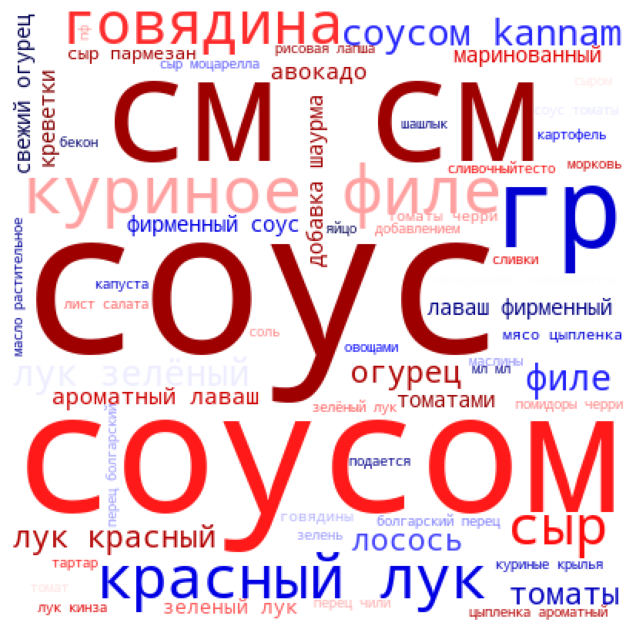

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

ingredients = []
for i in range(len(branch)):
    text = branch['ingredients'][i].split(',')
    text = ','.join(text)
    ingredients.append(text)
    
text = ' '.join(ingredients)

wordcloud = WordCloud(width=400, height=400, colormap='seismic', background_color='white', min_font_size=8).generate(text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [50]:
all_ingredients = [['лук'], ['авокадо'], ['курица'], ['сыр'], ['креветки'], ['бекон'], ['огурец']]


In [51]:
# for ingredient in ingredients_to_find:
#     df[ingredient] = 0




In [52]:
branch

,id,dish,ingredients
0,70000001056052192,"Шаурма ""Классика"" норм",ароматный лаваш капуста морковь свежий огурец ...
1,70000001056052192,"Шаурма ""Классика"" большая",ароматный лаваш капуста морковь свежий огурец ...
2,70000001056052192,"Шаурма ""Острая"" норм",шаурма классика перец халапеньо острый соуслюб...
3,70000001056052192,"Шаурма ""Острая"" большая",шаурма классика перец халапеньо острый соуслюб...
4,70000001056052192,"Шаурма ""Грибная"" норм",шаурма классикажареные грибылюбая добавка
...,...,...,...
1213,422740746329503,Суп сырный с грибами,сыр грибы картофель лук сливки зелень подается...
1214,422740746329503,Пицца Кантри,курица ветчина сыр помидоры маслины new соус р...
1215,422740746329503,Молочный коктейль,изготавливается основе мороженого фермерского ...
1216,422740746329503,Кесадия куриная,курица помидоры перец болгарский сыр соус кетч...


In [53]:
# import ast

# # Iterate over each row in the table
# for index, row in branch.iterrows():
#     ingredients = row["ingredients"].split()
#     for ingredient in all_ingredients:
#         if ingredient in ingredients:
#             # If the ingredient is found, set the corresponding column value to 1
#             branch.loc[index, ingredient] = 1
# branch['авокадо'].sum()


In [54]:
for ingredient in all_ingredients:
    branch[ingredient] = 0
# Проход по каждой строке таблицы
            
train_data = branch.copy()

In [55]:
branch

,id,dish,ingredients,лук,авокадо,курица,сыр,креветки,бекон,огурец
0,70000001056052192,"Шаурма ""Классика"" норм",ароматный лаваш капуста морковь свежий огурец ...,0,0,0,0,0,0,0
1,70000001056052192,"Шаурма ""Классика"" большая",ароматный лаваш капуста морковь свежий огурец ...,0,0,0,0,0,0,0
2,70000001056052192,"Шаурма ""Острая"" норм",шаурма классика перец халапеньо острый соуслюб...,0,0,0,0,0,0,0
3,70000001056052192,"Шаурма ""Острая"" большая",шаурма классика перец халапеньо острый соуслюб...,0,0,0,0,0,0,0
4,70000001056052192,"Шаурма ""Грибная"" норм",шаурма классикажареные грибылюбая добавка,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1213,422740746329503,Суп сырный с грибами,сыр грибы картофель лук сливки зелень подается...,0,0,0,0,0,0,0
1214,422740746329503,Пицца Кантри,курица ветчина сыр помидоры маслины new соус р...,0,0,0,0,0,0,0
1215,422740746329503,Молочный коктейль,изготавливается основе мороженого фермерского ...,0,0,0,0,0,0,0
1216,422740746329503,Кесадия куриная,курица помидоры перец болгарский сыр соус кетч...,0,0,0,0,0,0,0


In [56]:
train_data = branch.copy()

In [57]:
train_data.drop(['id','dish'], inplace=True, axis=1)
train_data['labels'] = train_data.iloc[:, 1:].values.tolist()
train_data.drop(train_data.columns.values[1:-1].tolist(), inplace=True, axis=1)
train_data.head()

,ingredients,labels
0,ароматный лаваш капуста морковь свежий огурец ...,"[0, 0, 0, 0, 0, 0, 0]"
1,ароматный лаваш капуста морковь свежий огурец ...,"[0, 0, 0, 0, 0, 0, 0]"
2,шаурма классика перец халапеньо острый соуслюб...,"[0, 0, 0, 0, 0, 0, 0]"
3,шаурма классика перец халапеньо острый соуслюб...,"[0, 0, 0, 0, 0, 0, 0]"
4,шаурма классикажареные грибылюбая добавка,"[0, 0, 0, 0, 0, 0, 0]"


In [58]:
train_data["ingredients"] = train_data["ingredients"].str.lower()
train_data["ingredients"] = train_data["ingredients"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

In [59]:
train_data

,ingredients,labels
0,ароматный лаваш капуста морковь свежий огурец ...,"[0, 0, 0, 0, 0, 0, 0]"
1,ароматный лаваш капуста морковь свежий огурец ...,"[0, 0, 0, 0, 0, 0, 0]"
2,шаурма классика перец халапеньо острый соуслюб...,"[0, 0, 0, 0, 0, 0, 0]"
3,шаурма классика перец халапеньо острый соуслюб...,"[0, 0, 0, 0, 0, 0, 0]"
4,шаурма классикажареные грибылюбая добавка,"[0, 0, 0, 0, 0, 0, 0]"
...,...,...
1213,сыр грибы картофель лук сливки зелень подается...,"[0, 0, 0, 0, 0, 0, 0]"
1214,курица ветчина сыр помидоры маслины new соус р...,"[0, 0, 0, 0, 0, 0, 0]"
1215,изготавливается основе мороженого фермерского ...,"[0, 0, 0, 0, 0, 0, 0]"
1216,курица помидоры перец болгарский сыр соус кетч...,"[0, 0, 0, 0, 0, 0, 0]"


In [60]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 1e-05
NUM_WORKERS = 1

In [61]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len: int, eval_mode: bool = False):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.text = dataframe.ingredients
        self.eval_mode = eval_mode 
        if self.eval_mode is False:
            self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        output = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }
                
        if self.eval_mode is False:
            output['targets'] = torch.tensor(self.targets.iloc[index], dtype=torch.float)
                
        return output

In [62]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
# model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

In [63]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny", truncation=True, do_lower_case=True)
training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)

In [64]:
training_set[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'ids': tensor([  101,  1180, 16856, 14150, 29745, 10260, 22919, 18947, 29113, 10325,
          1190, 10260, 25529, 10260, 29753,  1189, 10260, 29746, 29748, 29747,
         22919, 10260,  1191, 14150, 16856, 23925, 19259, 23742,  1196, 25529,
         15290, 29743, 15414,  1193, 29741, 29748, 16856, 15290, 29751,  1191,
         17432, 29747, 14150,  1189, 29748, 16856, 10325, 29751, 29113,  1196,
         14150, 29748, 29747,  1199, 10325, 16856, 29745, 15290, 18947, 18947,
         29113, 10325,  1191, 10260, 16856, 10325, 18947, 19259, 28995, 18947,
         29113, 10325,  1190, 29748, 23925,  1186, 15290, 29436, 28995, 10325,
         29757,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [65]:
from torch.nn.utils.rnn import pad_sequence

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS
                }


training_loader = DataLoader(training_set, **train_params)



In [66]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer


In [67]:

class DistilBERTClass(torch.nn.Module):
    
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = AutoModel.from_pretrained("cointegrated/rubert-tiny")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


In [68]:
# model = AutoModel.from_pretrained("cointegrated/rubert-tiny")


In [69]:
model = DistilBERTClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [70]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [71]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [72]:
def train(epoch):
    
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        targets = targets[:, :6]
        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()


In [73]:
# print(targets.size())


In [74]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:05, ?it/s]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [75]:
# test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_data = train_data.copy()

In [76]:
test_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN, eval_mode = True)
testing_params = {'batch_size': TRAIN_BATCH_SIZE,
               'shuffle': False,
               'num_workers': 2
                }
test_loader = DataLoader(test_set, **testing_params)

In [77]:
all_test_pred = []

def test(epoch):
    model.eval()
    
    with torch.inference_mode():
    
        for _, data in tqdm(enumerate(test_loader, 0)):


            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            outputs = model(ids, mask, token_type_ids)
            probas = torch.sigmoid(outputs)

            all_test_pred.append(probas)
    return probas

In [78]:
probas = test(model)

39it [13:33, 20.85s/it]


In [79]:
all_test_pred = torch.cat(all_test_pred)

In [90]:
submit_df = test_data.copy()


In [91]:
label_columns = ['лук','авокадо', 'курица','сыр','креветки','бекон']


In [92]:
for i,name in enumerate(label_columns):

    submit_df[name] = all_test_pred[:, i].cpu()
    submit_df.head()

In [93]:
submit_df.drop("labels", inplace=True, axis=1)

In [105]:
submit_df

,ingredients,лук,авокадо,курица,сыр,креветки,бекон
0,ароматный лаваш капуста морковь свежий огурец ...,0.466527,0.533463,0.538694,0.440428,0.556830,0.464865
1,ароматный лаваш капуста морковь свежий огурец ...,0.466527,0.533463,0.538694,0.440428,0.556830,0.464865
2,шаурма классика перец халапеньо острый соуслюб...,0.470723,0.528278,0.538364,0.440126,0.552285,0.463347
3,шаурма классика перец халапеньо острый соуслюб...,0.470723,0.528278,0.538364,0.440126,0.552285,0.463347
4,шаурма классикажареные грибылюбая добавка,0.469271,0.525623,0.540779,0.442410,0.551217,0.463211
...,...,...,...,...,...,...,...
1213,сыр грибы картофель лук сливки зелень подается...,0.480010,0.525350,0.537535,0.442627,0.553060,0.470673
1214,курица ветчина сыр помидоры маслины new соус р...,0.478303,0.528152,0.538073,0.442984,0.552075,0.473697
1215,изготавливается основе мороженого фермерского ...,0.477429,0.524367,0.535507,0.444720,0.556096,0.472912
1216,курица помидоры перец болгарский сыр соус кетч...,0.479327,0.526029,0.536891,0.445154,0.552634,0.471031


In [102]:
branch.drop(columns=['огурец'], inplace=True)

In [104]:
branch

,id,dish,ingredients
0,70000001056052192,"Шаурма ""Классика"" норм",ароматный лаваш капуста морковь свежий огурец ...
1,70000001056052192,"Шаурма ""Классика"" большая",ароматный лаваш капуста морковь свежий огурец ...
2,70000001056052192,"Шаурма ""Острая"" норм",шаурма классика перец халапеньо острый соуслюб...
3,70000001056052192,"Шаурма ""Острая"" большая",шаурма классика перец халапеньо острый соуслюб...
4,70000001056052192,"Шаурма ""Грибная"" норм",шаурма классикажареные грибылюбая добавка
...,...,...,...
1213,422740746329503,Суп сырный с грибами,сыр грибы картофель лук сливки зелень подается...
1214,422740746329503,Пицца Кантри,курица ветчина сыр помидоры маслины new соус р...
1215,422740746329503,Молочный коктейль,изготавливается основе мороженого фермерского ...
1216,422740746329503,Кесадия куриная,курица помидоры перец болгарский сыр соус кетч...


In [103]:
# submit_df
merged_df = pd.merge(submit_df, branch, on='ingredients')
merged_df

,ingredients,лук,авокадо,курица,сыр,креветки,бекон,id,dish
0,ароматный лаваш капуста морковь свежий огурец ...,0.466527,0.533463,0.538694,0.440428,0.556830,0.464865,70000001056052192,"Шаурма ""Классика"" норм"
1,ароматный лаваш капуста морковь свежий огурец ...,0.466527,0.533463,0.538694,0.440428,0.556830,0.464865,70000001056052192,"Шаурма ""Классика"" большая"
2,ароматный лаваш капуста морковь свежий огурец ...,0.466527,0.533463,0.538694,0.440428,0.556830,0.464865,70000001056052192,"Шаурма ""Классика"" норм"
3,ароматный лаваш капуста морковь свежий огурец ...,0.466527,0.533463,0.538694,0.440428,0.556830,0.464865,70000001056052192,"Шаурма ""Классика"" большая"
4,шаурма классика перец халапеньо острый соуслюб...,0.470723,0.528278,0.538364,0.440126,0.552285,0.463347,70000001056052192,"Шаурма ""Острая"" норм"
...,...,...,...,...,...,...,...,...,...
246933,сыр грибы картофель лук сливки зелень подается...,0.480010,0.525350,0.537535,0.442627,0.553060,0.470673,422740746329503,Суп сырный с грибами
246934,курица ветчина сыр помидоры маслины new соус р...,0.478303,0.528152,0.538073,0.442984,0.552075,0.473697,422740746329503,Пицца Кантри
246935,изготавливается основе мороженого фермерского ...,0.477429,0.524367,0.535507,0.444720,0.556096,0.472912,422740746329503,Молочный коктейль
246936,курица помидоры перец болгарский сыр соус кетч...,0.479327,0.526029,0.536891,0.445154,0.552634,0.471031,422740746329503,Кесадия куриная


In [106]:

merged_df.duplicated().sum()
merged_df.drop_duplicates(inplace=True)

merged_df.isnull().sum()
merged_df.dropna(how='any',inplace=True)

In [108]:
merged_df.to_csv('dishes.csv')